In [20]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
#matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.transform import resize
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

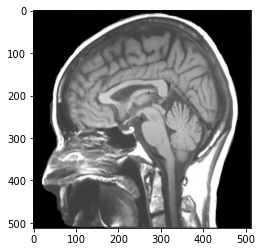

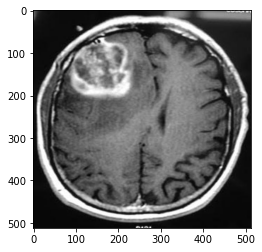

In [17]:
labels=pd.read_csv('./dataset/label_binary.csv',index_col=0)
#print(df.head())

def get_image(filename, root="dataset/image/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.label == 0.0].index[5]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.label == 1.0].index[6]

plt.imshow(get_image(bombus_row))
plt.show()

Color bombus image has shape:  [[[101 101 101]
  [100 100 100]
  [ 96  96  96]
  ...
  [138 138 138]
  [193 193 193]
  [234 234 234]]

 [[101 101 101]
  [100 100 100]
  [ 96  96  96]
  ...
  [205 205 205]
  [228 228 228]
  [245 245 245]]

 [[102 102 102]
  [100 100 100]
  [ 96  96  96]
  ...
  [237 237 237]
  [251 251 251]
  [255 255 255]]

 ...

 [[  7   7   7]
  [  7   7   7]
  [  7   7   7]
  ...
  [  7   7   7]
  [  7   7   7]
  [  7   7   7]]

 [[  7   7   7]
  [  7   7   7]
  [  7   7   7]
  ...
  [  7   7   7]
  [  7   7   7]
  [  7   7   7]]

 [[  7   7   7]
  [  7   7   7]
  [  7   7   7]
  ...
  [  7   7   7]
  [  7   7   7]
  [  7   7   7]]]
Greyscale bombus image has shape:  [[0.39607843 0.39215686 0.37647059 ... 0.54117647 0.75686275 0.91764706]
 [0.39607843 0.39215686 0.37647059 ... 0.80392157 0.89411765 0.96078431]
 [0.4        0.39215686 0.37647059 ... 0.92941176 0.98431373 1.        ]
 ...
 [0.02745098 0.02745098 0.02745098 ... 0.02745098 0.02745098 0.02745098]
 [0.027

C:\Users\jerem\AppData\Local\Temp/ipykernel_10332/53878836.py:7: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  grey_bombus = rgb2grey(bombus)


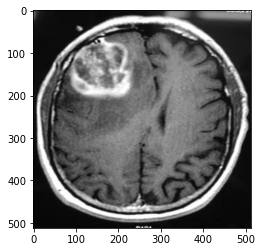

In [22]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

print('Color bombus image has shape: ', bombus)

# convert the bombus image to greyscale
grey_bombus = rgb2grey(bombus)

plt.imshow(grey_bombus, cmap=mpl.cm.gray)

print('Greyscale bombus image has shape: ', grey_bombus)

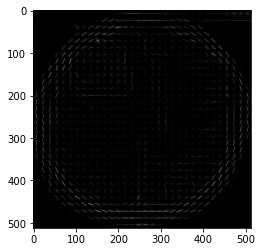

In [23]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)

In [24]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

bombus_features = create_features(bombus)

print(bombus_features)

C:\Users\jerem\AppData\Local\Temp/ipykernel_10332/3075710503.py:5: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  grey_image = rgb2grey(img)


[101 101 101 ...   7   7   7]


In [14]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [02:44<00:00, 18.23it/s]


Feature matrix shape is:  (3000, 72900)


In [15]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

PCA matrix shape is:  (3000, 3000)


In [6]:
X = pd.DataFrame(bees_pca)
y = pd.Series(labels.genus.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1    2037
0     363
dtype: int64

In [7]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [8]:
# define support vector classifier
#svm2 = SVC(kernel='sigmoid', probability=True, random_state=42)

# fit model
#svm2.fit(X_train, y_train)

In [9]:
# generate predictions
y_pred = svm.predict(X_test)
#y_pred2 = svm2.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
#accuracy = [accuracy_score(y_test, y_pred),accuracy_score(y_test, y_pred2)]
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.96


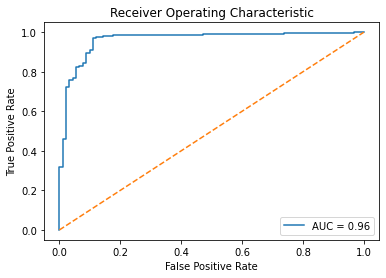

In [10]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_prob = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');